In [1]:
## This script is to evaluate POD CSI FAR of the CTT tracking
## created by C. Bayu Risanto, S.J. (25 June 2024)
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from numpy import matlib
import pandas as pd
import os
from os.path import exists
import xarray as xr
from scipy.io import loadmat,savemat 
from datetime import date, datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mplotcolors
import matplotlib as mp
from matplotlib import cm
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from CSIPODFAR_stats import F_rainmetrics_NV9, F_rainmetrics_NV25, F_rainmetrics_NV49

## create ncfile opener
def read_ncrain(ncfile):
    ds = xr.open_dataset(ncfile)
    rainds = ds.RAINNC_reg2[:,:,:]
    return rainds

def read_obrain(ncfile):
    ob = xr.open_dataset(ncfile)
    rainob = ob.PRECIP[:,:,:]
    return rainob


In [2]:
## days of rain
DR = ['2021-07-03','2021-07-09','2021-07-10','2021-07-12','2021-07-13','2021-07-14',
      '2021-07-15','2021-07-16','2021-07-18','2021-07-21','2021-07-22','2021-07-23',
      '2021-07-24','2021-07-25','2021-07-29','2021-07-30','2021-08-10','2021-08-11',
      '2021-08-13','2021-08-15','2021-08-16','2021-08-30','2021-08-31','2021-09-01']

In [13]:
## read rainnc ; it is accumulated rainnc
cat = 'noassim'
linkwrf = '/net/brisa/br1/castrogroup/bayu/UA-WRF/ARIZONA_PRO/WRF_EXTR/regRAINNC'
f = 'RAINNC_d02_reg2MRMS.AZ+.nc'
d18 = []
for iD in range(len(DR)):
    dwrf = DR[iD][0:4]+DR[iD][5:7]+DR[iD][8:10]+'_06Z_mc08_40mem_0035_6cyc_'+cat
    dwrf = read_ncrain(linkwrf+'/'+dwrf+'/'+f)
    d18.append(dwrf[-1,:,:])  #get only the total last hour (18 hr total)
d18 = np.asarray(d18); print(d18.shape)

(24, 651, 612)


In [14]:
## read OBS
## create day times
daystrform = '%Y-%m-%d'
daySta = [datetime.strptime(DR[i],daystrform) for i in range(len(DR))]
dayEnd = [(datetime.strptime(DR[i],daystrform)) + timedelta(days=1) for i in range(len(DR))]

PCP_AL = []
for itime in range(len(DR)):
    day_st = str(daySta[itime])[0:10]
    day_en = str(dayEnd[itime])[0:10]
    datestrform = '%Y-%m-%dT%H'
    date_st = datetime.strptime(day_st + 'T18',datestrform)
    date_en = datetime.strptime(day_en + 'T12',datestrform)
    dateList = [date_st.strftime(datestrform)]
    date_time = date_st
    while date_time < date_en:
        date_time += timedelta(hours=1)
        dateList.append(date_time.strftime(datestrform))
    dateList = np.asarray(dateList)

    ## hourly precip and save the dates and hours
    link = '/net/brisa/br1/castrogroup/bayu/DYLAN-DATA/MRMS/ncfiles/'
    pcp_hr_al = []
    for i in range(len(dateList)):
        yy = str(dateList[i]); YYYY = yy[0:4]
        mm = str(dateList[i]); MM = mm[5:7]
        dd = str(dateList[i]); DD = dd[8:10]
        hh = str(dateList[i]); HH = hh[11:13]
        nc_hour = 'MultiSensor_QPE_01H_Pass2_00.00_'+YYYY+MM+DD+'-'+HH+'0000_AZ.nc'
        if exists(link + nc_hour) == True:
            pcp_hr = read_obrain(link+nc_hour)
            pcp_hr_al.append(np.squeeze(pcp_hr))
        al_pcp_hr = np.asarray(pcp_hr_al)
    PCP_AL.append(al_pcp_hr)
PCP_4D = np.asarray(PCP_AL)

## calculate total 18 hours 
day_PCP = np.sum(PCP_4D,axis=1)

In [15]:
print(day_PCP.shape)

(24, 651, 612)


In [16]:
## run stat analyses
thres = 9.4
thst = str(thres)
CSI,POD,FAR,stat = F_rainmetrics_NV25(d18[:,:,:],day_PCP[:,:,:],thres)

In [17]:
## PLOT ##
## get latlon
ds = xr.open_dataset(linkwrf+'/'+'20210703_06Z_mc08_40mem_0035_6cyc_assim'+'/'+'RAINNC_d02_reg2MRMS.AZ+.nc')
lat = ds.lat[:]
lon = ds.lon[:]
xlon = np.matlib.repmat(lon,len(lat),1)
xlat = np.matlib.repmat(lat,len(lon),1).T

In [18]:
## get contour hgt
ds = xr.open_dataset('/net/haze/ha1/jmoker/bayu/HGT_d01.nc')
HGT = ds.HGT[0,:,:]
XLAT = ds.XLAT[0,:,:]
XLON = ds.XLONG[0,:,:]

## get rid of anything less than 0 m
HGT = HGT.where(HGT >= 1)

In [19]:
xticks = np.arange(-115.,-109,1)
yticks = np.arange(31.,38.,1)
## create background
crs = ccrs.PlateCarree()
def plot_background(ax):
    ax.set_extent([-115.,-109.,31.,37.5], ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'),linewidth=1.4,zorder=3)
    #ax.add_feature(cfeature.BORDERS,linestyle=':',linewidth=0.7,zorder=3)
    ax.add_feature(cfeature.STATES,linestyle=':',linewidth=0.7,zorder=3)
    ax.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax.set_yticks(yticks, crs=ccrs.PlateCarree())
    ax.set_xticklabels(xticks, rotation=0, fontsize=12)
    ax.set_yticklabels(yticks, rotation=0, fontsize=12)
    ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.contour(XLON,XLAT,HGT,6,vmin=0,vmax=2500,colors='k',linewidths=0.6)
    
    gl = ax.gridlines(ccrs.PlateCarree(),draw_labels=False,linewidth=2,color='gray',
                     alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.xlabels_bottom = False
    gl.ylabels_left = False
    gl.ylabels_right = False
    gl.xlines = False; gl.ylines = False
    gl.xlocator = mticker.FixedLocator(xticks)
    gl.ylocator = mticker.FixedLocator(yticks)
    
    return ax

In [20]:
# set colors and colorbar
cmap1 = cm.get_cmap('jet', 11)    # PiYG
col_list1 = []
for i in range(cmap1.N):
    rgba = cmap1(i)
    # rgb2hex accepts rgb or rgba
    color = mp.colors.rgb2hex(rgba)
    col_list1.append(color)
#print(col_list1)
varval1 = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
           0.8, 0.9, 1]
density_cmap1 = mplotcolors.ListedColormap(col_list1,'density')
adjnorm1 = mplotcolors.BoundaryNorm(varval1,density_cmap1.N)

varval2 = np.arange(-0.5,0.6,0.1)

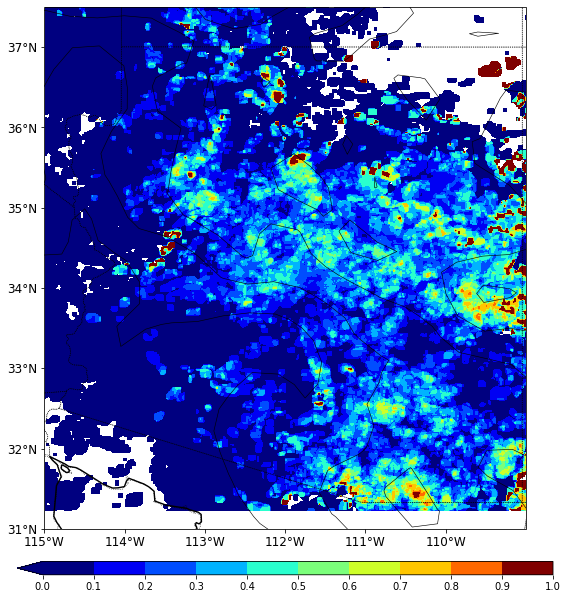

In [21]:
###########################################
# Plot Rain total #           
###########################################
projection = ccrs.PlateCarree()
fig, ax1 = plt.subplots(1, 1, figsize=(12, 12),
                                   subplot_kw={'projection': projection})
## AX1
plot_background(ax1)

dens1 = ax1.contourf(xlon,xlat,POD,
                     #cmap=cmap1,vmin=0,vmax=1,shading='nearest',alpha=1)
                     varval1,cmap=cmap1,norm=adjnorm1,extend='min',transform=projection,)


##Add precip colorbar
cbar = fig.colorbar(dens1,ticks=varval1,ax=ax1,orientation='horizontal',shrink=0.8,aspect=40,pad=0.05)

## CLOSE
plt.show()

plt.close()

In [22]:
## We may want to save the data in mat file for further use
linkout = '/net/brisa/br1/castrogroup/bayu/UA-WRF/ARIZONA_PRO/WRF_EXTR'
dir_out = linkout+'/'+'CSIPODFAR_AZ+'
output_file = dir_out +'/'+ 'CSIPODFAR_RAINNC_'+cat+'_NV25_'+'thr'+thst+'.mat'
mdic = {'CSI':CSI,'POD':POD,'FAR':FAR}
savemat(output_file,mdic)

## save also the rainnc and obs rain in the summary
dir_out = linkout+'/'+'regRAINNC/summary'
output_file = dir_out+'/'+'18hour_accum_'+cat+'.RAINNC+OBS_AZ+.mat' ## change here DA or NODA
mdic = {'RAINNC18h':d18,'Obs18h':day_PCP}
savemat(output_file,mdic)